In [1]:
import pandas as pd
import sqlite3
from sqlite3 import connect
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import pairwise_distances
import scipy.sparse
import pickle

In [2]:
#print(os.path.isfile('train.db'))
if not os.path.isfile('train.db'):
  #print(1)
  start = datetime.now()
  disk_engine = create_engine('sqlite:///train.db')
  start = datetime.now()
  chunksize = 18000
  j = 0
  index_start = 1
  for df in pd.read_csv('/kaggle/input/train-search-engine/Train.csv', names = ['Id','Title', 'Body','Tags'], chunksize = chunksize) : 
    df.index += index_start
    j+=1
    print( '{} rows'.format(j*chunksize))
    df.to_sql('data', disk_engine, if_exists = 'append')
    index_start = df.index[-1] +1
  print("Time to run ",datetime.now()-start)
#df.head(20)

18000 rows
36000 rows
54000 rows
72000 rows
90000 rows
108000 rows
126000 rows
144000 rows
162000 rows
180000 rows
198000 rows
216000 rows
234000 rows
252000 rows
270000 rows
288000 rows
306000 rows
324000 rows
342000 rows
360000 rows
378000 rows
396000 rows
414000 rows
432000 rows
450000 rows
468000 rows
486000 rows
504000 rows
522000 rows
540000 rows
558000 rows
576000 rows
594000 rows
612000 rows
630000 rows
648000 rows
666000 rows
684000 rows
702000 rows
720000 rows
738000 rows
756000 rows
774000 rows
792000 rows
810000 rows
828000 rows
846000 rows
864000 rows
882000 rows
900000 rows
918000 rows
936000 rows
954000 rows
972000 rows
990000 rows
1008000 rows
1026000 rows
1044000 rows
1062000 rows
1080000 rows
1098000 rows
1116000 rows
1134000 rows
1152000 rows
1170000 rows
1188000 rows
1206000 rows
1224000 rows
1242000 rows
1260000 rows
1278000 rows
1296000 rows
1314000 rows
1476000 rows
1494000 rows
1512000 rows
1530000 rows
1548000 rows
1566000 rows
1584000 rows
1602000 rows
1620000

In [3]:
df.head(20)

,Id,Title,Body,Tags
1019070001,6030000,rdiff-backup restoring directories without sub...,<p>Is there a way to restore rdiff-backup gene...,backup restore rdiff-backup
1019070002,6030001,How do I restrict a users access to an object?,"<p>Hi Sitepoint wizard people,</p>\n\n<p>Say w...",mvc authorization access-control
1019070003,6030002,Multithread testing,<p>I have a task to firstly write a multithrea...,java multithreading testing
1019070004,6030003,Check whether a file is open in Matlab,<p>I'm downloading some big files(2GB) and als...,file matlab ubuntu filesystems
1019070005,6030004,Coherent read-only view of a database,<p>I would like to perform a select query that...,sql database
1019070006,6030005,How to properly close a socket after an except...,<p>After my last project I had the problem tha...,java exception-handling sockets
1019070007,6030006,Appending a GET-Variable to wp_nav_menu,<p>I'm creating a menu with the wp_nav_menu() ...,menus
1019070008,6030007,SaveAs Method for ApplicationSettingsBase,<p>How can I do a <em>SaveAs(string file)</em>...,.net configuration-files
1019070009,6030008,ModalViewCOntroller in NavigationController,<p>I have a NavigationController that present ...,iphone objective-c data uinavigationcontroller...
1019070010,6030009,WCF service reference Client config not config...,<p>I am very new to WCF Web service. I am deve...,c# wcf windows-phone-7


In [4]:
con = sqlite3.connect('train.db')
count = pd.read_sql_query("""SELECT count(*) FROM data""", con)
print("Total rows in training set = ", count["count(*)"])

Total rows in training set =  0    6034196
Name: count(*), dtype: int64


In [5]:
con.close()
con = sqlite3.connect('train.db')
df = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags',con)
con.close()
df.head(20)

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2
5,Better way to update feed on FB with PHP SDK,<p>I am a novice with the Facebook API. I have...,facebook api facebook-php-sdk,1
6,btnAdd click event opens two window after r...,<p>i m opening window(search.aspx)using below ...,javascript asp.net web,3
7,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1
8,Countable subadditivity of the Lebesgue measure,<p>Let $\lbrace F_n \rbrace$ be a sequence of ...,real-analysis measure-theory,3
9,HQL equivalent to this Sql Query,"<pre><code>select part.PaId,part.PaName,part.P...",hibernate hql,2


<AxesSubplot:>

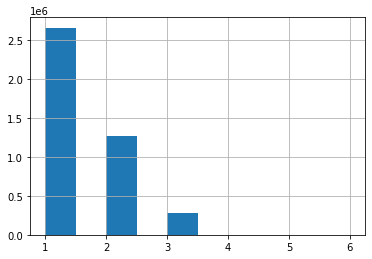

In [6]:
df.cnt_dup.hist()

In [7]:
df.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [8]:
del count

In [9]:
df = df[df.cnt_dup <2]
df = df.reset_index(drop = True)
df.head(20)

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,Better way to update feed on FB with PHP SDK,<p>I am a novice with the Facebook API. I have...,facebook api facebook-php-sdk,1
5,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1
6,Undefined symbols for architecture i386: _OB...,<p>I have imported framework for sending email...,iphone email-integration,1
7,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss,1
8,obtaining updated locations using gps in ser...,<p>I have app in which i have two buttons <str...,android android-widget android-service,1
9,"""Specified initialization vector (IV) does no...",<p>I've had troubles using an CryptoStream for...,c# .net rijndaelmanaged cryptostream,1


In [10]:
from tqdm import tqdm
import multiprocessing
def seperate(a ,l, r):
    tags = ["c#","java", "asp.net", "c++", "c", "ios" ]
    for i in tqdm(range(l,r)):
        for k in tags:
            if(df.iloc[i].Tags is not None) and k in df.iloc[i].Tags.split():
                a.append(i)
                break
    return a
start = datetime.now()
print(datetime.now() - start)

0:00:00.000055


In [11]:
from multiprocessing import Pool
manager = multiprocessing.Manager()
shared_list = manager.list()
p1 = multiprocessing.Process(target = seperate, args = [shared_list, 0, 885427])
p2 = multiprocessing.Process(target = seperate, args = [shared_list, 885427, 1770854])
p3 = multiprocessing.Process(target = seperate, args = [shared_list, 1770854, df.shape[0]])

p1.start()
p2.start()
p3.start()

100%|██████████| 885430/885430 [33:14<00:00, 443.89it/s]


In [12]:
b = []
b.extend(shared_list)
len(b)

27

In [13]:
df = df.iloc[b]
df = df.reset_index(drop = True)
df.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss,1
4,"""Specified initialization vector (IV) does no...",<p>I've had troubles using an CryptoStream for...,c# .net rijndaelmanaged cryptostream,1


In [14]:
if not os.path.isfile('without_duplicates.db'):
    disk_dup = create_engine("sqlite:///without_duplicates.db")
    no_dup = pd.DataFrame(df, columns = ['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [15]:
con = sqlite3.connect('without_duplicates.db')
k = pd.read_sql_query("""SELECT * FROM no_dup_train""",con)
con.close()

In [16]:
k = k.drop(["index"], axis = 1)

In [17]:
k.head()

,Title,Body,Tags
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns
3,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss
4,"""Specified initialization vector (IV) does no...",<p>I've had troubles using an CryptoStream for...,c# .net rijndaelmanaged cryptostream


In [18]:
f = k.Body.iloc[3]

In [19]:
f

'<p>i want to have a servlet to process inputs from a standalone java program. how to deploy this servlet in jboss. I put the servlet.class file in WEB-INF/classes and in web.xml i gave the servlet url mapping as ".do". From my Java client program i opened connected to the servlet using a URL object. using localhost:8080/.do. BUT i am getting the folowing error:</p>\n\n<pre>\n  ERROR [org.apache.catalina.connector.CoyoteAdapter] An exception or error occurred in the container during the request processing: \n  java.lang.NoSuchMethodError: javax.servlet.ServletContext.getEffectiveSessionTrackingModes()Ljava/util/Set;\n            at\n     org.apache.catalina.connector.CoyoteAdapter.postParseRequest(CoyoteAdapter.java:567)\n            at org.apache.catalina.connector.CoyoteAdapter.service(CoyoteAdapter.java:359)\n            at org.apache.coyote.http11.Http11Processor.process(Http11Processor.java:877)\n            at org.apache.coyote.http11.Http11Protocol$Http11ConnectionHandler.proces

Preprocessing starts here

In [20]:
con = sqlite3.connect('without_duplicates.db')
k = pd.read_sql_query("""SELECT * FROM no_dup_train""" , con)
con.close()

In [21]:
k = k.drop(["index"], axis = 1)
k.head()

,Title,Body,Tags
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns
3,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss
4,"""Specified initialization vector (IV) does no...",<p>I've had troubles using an CryptoStream for...,c# .net rijndaelmanaged cryptostream


In [22]:
f = k.iloc[1]
f

Title             Dynamic Datagrid Binding in Silverlight?
Body     <p>I should do binding for datagrid dynamicall...
Tags                           c# silverlight data-binding
Name: 1, dtype: object

#Cleaning Title of questions
#Removing Redundant spaces
#Removing Stopwords
#Removing curly brackets

In [23]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [24]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
for sentence in tqdm(k.Title.values):
#for sentence in tqdm(k.Tag.values):
  sentence = re.sub(r"http\S+", "", sentence)
  sentence = BeautifulSoup(sentence, 'lxml').get_text()
  sentence = re.sub("\S*\d\S*", "", sentence).strip()
  sentence = re.sub('[^A-Za-z]+', ' ',sentence)
  sentence = ' '.join(e.lower() for e in sentence.split() if e.lower()not in stopwords.words('english'))
  preprocessed_reviews.append(sentence.strip())

  0%|          | 0/27 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 27/27 [00:00<00:00, 274.47it/s]


In [25]:
k.Title = preprocessed_reviews

In [26]:
new_tags = []
for i in tqdm(range(k.shape[0])):
  j = k.Tags.iloc[i].split()[0]
  new_tags.append(j)

100%|██████████| 27/27 [00:00<00:00, 18303.90it/s]


In [27]:
k.Tags = new_tags
k.head()


,Title,Body,Tags
0,implementing boundary value analysis software ...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++
1,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,c#
2,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,c#
3,java lang nosuchmethoderror javax servlet serv...,<p>i want to have a servlet to process inputs ...,java
4,specified initialization vector iv match block...,<p>I've had troubles using an CryptoStream for...,c#


In [28]:
k.describe()

,Title,Body,Tags
count,27,27,27
unique,26,26,7
top,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,c#
freq,2,2,14


In [29]:
k.Tags.describe()

count     27
unique     7
top       c#
freq      14
Name: Tags, dtype: object

In [30]:
k.groupby(["Tags"]).describe()

Title                                                            \
            count unique                                                top   
Tags                                                                          
asp.net         2      2  selcurrentmanuf declared may inaccessible due ...   
c#             14     13               dynamic datagrid binding silverlight   
c++             3      3  implementing boundary value analysis software ...   
iphone          1      1                                  debug ios devices   
java            5      5  java lang nosuchmethoderror javax servlet serv...   
javascript      1      1                 best calculate bytes text textarea   
objective-c     1      1    best compare two nsstring objects ignoring case   

                  Body         \
            freq count unique   
Tags                            
asp.net        1     2      2   
c#             2    14     13   
c++            1     3      3   
iphone         1     1      1   
java           1     5      5   
javascript     1     1      1   
objective-c    1     1      1   

                                                                     
                                                           top freq  
Tags                                                                 
asp.net      <p>i have a drop down list i am trying to use ...    1  
c#           <p>I should do binding for datagrid dynamicall...    2  
c++          <pre><code>#include&lt;iostream&gt;\n#include&...    1  
iphone       <p>Whenever I try to debug on devices with iOS...    1  
java         <p>i want to have a servlet to process inputs ...    1  
javascript   <p>I need to find a way to accurately calculat...    1  
objective-c  <p>I want to compare two strings. It fails whe...    1

In [31]:
k[k.Tags == "2007"]
tag_list = ["c#", "java", "c++", "ios", "c"]

In [32]:
new_indices = []
for i in tqdm(range(k.shape[0])):
    for j in tag_list:
        if j == k.Tags.iloc[i]:
            new_indices.append(i)
            break

100%|██████████| 27/27 [00:00<00:00, 13902.06it/s]


In [33]:
len(new_indices)

22

In [34]:
k = k.iloc[new_indices]

In [35]:
k.groupby(["Tags"]).describe()

Title                                                                 \
     count unique                                                top freq   
Tags                                                                        
c#      14     13               dynamic datagrid binding silverlight    2   
c++      3      3  implementing boundary value analysis software ...    1   
java     5      5  java lang nosuchmethoderror javax servlet serv...    1   

      Body                                                                 
     count unique                                                top freq  
Tags                                                                       
c#      14     13  <p>I should do binding for datagrid dynamicall...    2  
c++      3      3  <pre><code>#include&lt;iostream&gt;\n#include&...    1  
java     5      5  <p>i want to have a servlet to process inputs ...    1

In [36]:
if not os.path.isfile('processed.db'):
    processed = create_engine("sqlite:///processed.db")
    k.to_sql('processed',processed)

In [37]:
con = sqlite3.connect('processed.db')
processed = pd.read_sql_query("""SELECT * FROM processed""", con)
con.close()

In [38]:
processed.head()

,index,Title,Body,Tags
0,0,implementing boundary value analysis software ...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++
1,1,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,c#
2,2,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,c#
3,3,java lang nosuchmethoderror javax servlet serv...,<p>i want to have a servlet to process inputs ...,java
4,4,specified initialization vector iv match block...,<p>I've had troubles using an CryptoStream for...,c#


In [39]:
del k

SEARCHENGINE


In [40]:
vectorizer = CountVectorizer()
bow_features = vectorizer.fit_transform(processed['Title'])
bow_features.get_shape()

(22, 98)

In [41]:
tfidf = TfidfVectorizer()
tfidf_features = tfidf.fit_transform(processed.Title)
tfidf_features.get_shape()

(22, 98)

In [42]:
def process_query(query):
  preprocessed_reviews = []
  sentence = re.sub("\S*\d\S*", "", query).strip()
  sentence = re.sub('[^A-Za-z]+', ' ', sentence)
  sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords.words('english'))
  preprocessed_reviews.append(sentence.strip())
  return preprocessed_reviews
  

In [43]:
from sklearn.metrics.pairwise import pairwise_distances
def tfidf_search(tfidf, query):
  query = process_query(query)
  query_trans = tfidf.transform(query)
  pairwise_dist = pairwise_distances(tfidf_features, query_trans)
  indices = np.argsort(pairwise_dist.flatten())[0:10]
  df_indices = list(processed.index[indices])
  return df_indices
  

In [44]:
def bow_search(vectorizer, query):
  query = process_query(query)
  query_trans = vectorizer.transform(query)
  pairwise_dist = pairwise_distances(bow_features, query_trans)
  indices = np.argsort(pairwise_dist.flatten())[0:10]
  df_indices = list(processed.index[indices])
  return df_indices

In [45]:
def search(query, typ = "tfidf"):
  if typ == "tfidf":
    val = tfidf_search(tfidf, query)
  else:
    val = bow_search(vectorizer, query)
  return val

In [46]:
query = "synchronization "
df_indices = search(query)

In [47]:
print("The query is: ",query)
print("The top prediced results are: ")
for i in df_indices:
  print("Title: ", processed.Title.iloc[i])

The query is:  synchronization 
The top prediced results are: 
Title:  best convert stack trace html using net c
Title:  best cache server responses server side jetty spring
Title:  comparing value datatable
Title:  best clear variable lot objects
Title:  best clean sqldatareader using linq
Title:  collectionassert use generics
Title:  reach storyboard object c
Title:  c linker error
Title:  c overloading operator
Title:  boolean inside select


In [48]:
df_indices = search(query, "bow")
print("The top prediced results are: ")
for i in df_indices:
  print("Title: ", processed.Title.iloc[i])

The top prediced results are: 
Title:  adapter pattern
Title:  c overloading operator
Title:  c linker error
Title:  comparing value datatable
Title:  things division zero c
Title:  collectionassert use generics
Title:  boolean inside select
Title:  reach storyboard object c
Title:  dynamic datagrid binding silverlight
Title:  dynamic datagrid binding silverlight


Classification

In [49]:
labels = {"c#" : 0, "java": 1, "c++": 2, "c" : 3, "ios":4 }
labels_map = {0 :"c#" , 1: "java", 2: "c++", 3: "c", 4: "ios"}


In [50]:
processed["Tags"] = processed["Tags"].map(labels)

In [51]:
processed.head(20)

,index,Title,Body,Tags
0,0,implementing boundary value analysis software ...,<pre><code>#include&lt;iostream&gt;\n#include&...,2
1,1,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,0
2,2,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,0
3,3,java lang nosuchmethoderror javax servlet serv...,<p>i want to have a servlet to process inputs ...,1
4,4,specified initialization vector iv match block...,<p>I've had troubles using an CryptoStream for...,0
5,6,things division zero c,<blockquote>\n <p><strong>Possible Duplicate:...,2
6,7,adapter pattern,<p>I have a problem in which I have to copy da...,0
7,9,alternate ways store data,<p>Hey guys I'm searching for an alternative w...,0
8,10,android make spinner show item selecting items...,<p>This is my code:</p>\n\n<pre><code> pack...,1
9,11,way using java nio interrupt inputstream read ...,<p>Do you know of a way to interrupt a read fr...,1


In [52]:
x = processed.Title.values
y = processed.Tags.values
y

array([2, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0])

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, stratify = y)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size = 0.25, stratify = Y_train)

In [54]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_cv = tfidf.transform(X_cv)
X_test = tfidf.transform(X_test)
X_train.shape, X_cv.shape, X_test.shape

((12, 51), (5, 51), (5, 51))

In [55]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [72]:
from sklearn.metrics import accuracy_score
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 0.1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1]):
  clf = SGDClassifier(alpha = i, loss = "log", class_weight = "balanced", n_jobs = -1)
  clf.fit(X_train, Y_train)
  Y_predict = clf.predict(X_train)
  Y_predict_cv = clf.predict(X_cv)
  score_train.append(accuracy_score(Y_train, Y_predict))
  score_cv.append(accuracy_score(Y_cv, Y_predict_cv))

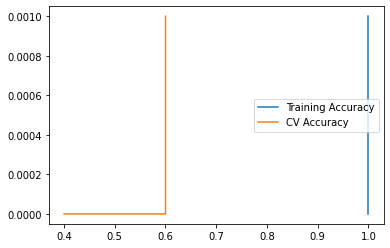

In [73]:
import matplotlib.pyplot as plt
lis = [0.000000001 ,0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001]
plt.plot(score_train[:-2], lis, label = "Training Accuracy")
plt.plot(score_cv[:-2],lis,label = "CV Accuracy")
plt.legend()
plt.show()

In [74]:
best_alpha = 0.0000001

In [75]:
from sklearn.metrics import confusion_matrix
clf = SGDClassifier(alpha = best_alpha, loss = "log", class_weight = "balanced", n_jobs = -1)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
cm = confusion_matrix(Y_test, Y_predict)
print("The accuracy of the model is: ", acc)

The accuracy of the model is:  0.6


<AxesSubplot:>

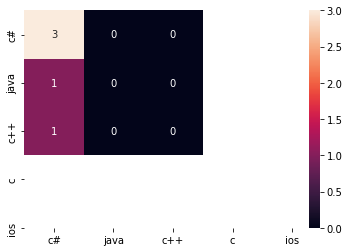

In [76]:
x_axis = ["c#" , "java", "c++", "c", "ios"]
y_axis = ["c#" , "java", "c++", "c", "ios"]
sns.heatmap(cm, annot = True, fmt = "d", xticklabels = x_axis, yticklabels = y_axis)


SVM

In [77]:
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 1e-7, 1e-6, 0.00001, 0.0001]):
    clf = SGDClassifier(alpha = i, class_weight="balanced", n_jobs=-1)
    clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_train)
    Y_predict_cv = clf.predict(X_cv)
    score_train.append(accuracy_score(Y_train, Y_predict))
    score_cv.append(accuracy_score(Y_cv, Y_predict_cv))

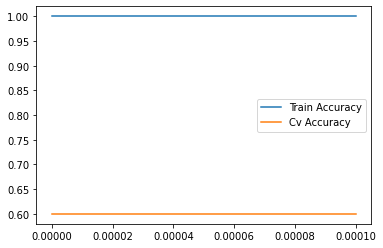

In [78]:
lis = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]
plt.plot(lis, score_train, label = "Train Accuracy")
plt.plot(lis, score_cv, label = "Cv Accuracy")
plt.legend()
plt.show()

In [79]:
best_alpha = 1e-6

The Accuracy of model is :  0.6


<AxesSubplot:>

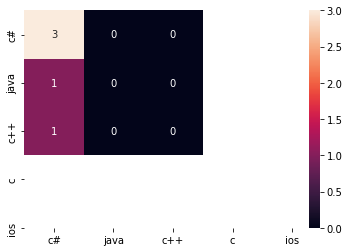

In [80]:
clf = SGDClassifier(alpha = best_alpha, class_weight="balanced", n_jobs=-1)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
cm = confusion_matrix(Y_test, Y_predict)
print("The Accuracy of model is : ", acc)
sns.heatmap(cm, annot = True, fmt="d", xticklabels = x_axis, yticklabels = y_axis)

For Bigrams

In [81]:
import random
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, stratify = y_train)
X_train.shape, X_test.shape, X_cv.shape


((12,), (5,), (5,))

In [82]:
tfidf = TfidfVectorizer(ngram_range=(2,2))
X_train = tfidf.fit_transform(X_train)
X_cv = tfidf.transform(X_cv)
X_test = tfidf.transform(X_test)
X_train.shape, X_cv.shape, X_test.shape

((12, 49), (5, 49), (5, 49))

In [83]:
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 1e-7, 1e-6, 0.00001, 0.0001]):
    clf = SGDClassifier(alpha = i, loss = "log", class_weight="balanced", n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    y_predict_cv = clf.predict(X_cv)
    score_train.append(accuracy_score(y_train, y_predict))
    score_cv.append(accuracy_score(y_cv, y_predict_cv))

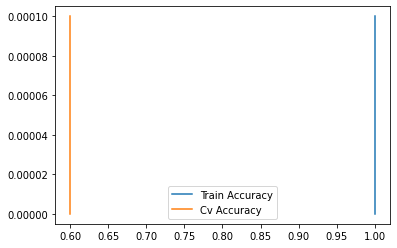

In [84]:
lis = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]
plt.plot(score_train, lis, label = "Train Accuracy")
plt.plot(score_cv, lis, label = "Cv Accuracy")
plt.legend()
plt.show()


In [85]:
# CASE OF OVERFITTING
best_alpha = 0.000001

In [86]:
clf = SGDClassifier(alpha = best_alpha, loss = "log", class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print("The Accuracy of model is : ", acc)

The Accuracy of model is :  0.6


In [87]:
# Hence Bigrams are not useful so no need to go further for checking
# So lets Take our clf_final which is classifier from LR on Unigram